<a href="https://colab.research.google.com/github/DataJenius/NLPEncodingExperiment/blob/main/python/NLPEncodingExperiment_word2vec300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#######################################################################################################
# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()

Finished!


In [2]:
###########################################
# load all dependencies
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from stepbystep.v4 import StepByStep

from google.colab import files

In [3]:
######################################################################################
# our one-hot encoded data is on github
all_files = ['https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/word2vec300/word2vec_encoded300_group1.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/word2vec300/word2vec_encoded300_group2.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/word2vec300/word2vec_encoded300_group3.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/word2vec300/word2vec_encoded300_group4.csv',
             'https://raw.githubusercontent.com/DataJenius/NLPEncodingExperiment/main/data/input/word2vec300/word2vec_encoded300_group5.csv']
# concat into a single dataframe and shuffle the contents
df_from_each_file = (pd.read_csv(f) for f in all_files)
df_all_data   = pd.concat(df_from_each_file, ignore_index=True)
df_all_data = df_all_data.sample(frac=1).reset_index(drop=True)

# make sure we loaded what we think we did
print(df_all_data.head())
print(df_all_data.shape)

   msg_id  token_count  my_group   my_role  label     dim 1     dim 2  \
0   20030           25         4  validate      0  0.007102  0.011251   
1   45715           23         2     train      1 -0.001831  0.012220   
2   18243           22         2     train      0  0.002737  0.014752   
3   44581           23         3     train      1  0.007504  0.009248   
4   24220           64         4  validate      1 -0.011477  0.034345   

      dim 3     dim 4     dim 5  ...   dim 291   dim 292   dim 293   dim 294  \
0  0.003714  0.034432 -0.014015  ... -0.023575  0.005898 -0.035482  0.030581   
1 -0.000030  0.027602 -0.014948  ... -0.012737  0.016290 -0.020252  0.023577   
2  0.006371  0.027839 -0.013343  ... -0.009499  0.011314 -0.021866  0.009938   
3 -0.000348  0.037319 -0.018900  ... -0.013795  0.005359 -0.020177  0.019026   
4 -0.003589  0.086999 -0.027017  ... -0.043458  0.031262 -0.063757  0.053770   

    dim 295   dim 296   dim 297   dim 298   dim 299   dim 300  
0 -0.013116 -0.0

In [4]:
######################################################################################
# our data is already split into 5 groups, encoded and fully labelled

# setup this experiment
test_input_method = 'word2vec (300)'
print(test_input_method+" loading data...")

# split into val/test/train based on validation group 
df_train = df_all_data.loc[df_all_data['my_group'].isin([1,2,3])]
df_val = df_all_data.loc[df_all_data['my_group'] == 4]
df_test = df_all_data.loc[df_all_data['my_group'] == 5]

print("\n\ntrain - groups ",df_train['my_group'].unique())
print(df_train.head())
print("\n\nval - group ",df_val['my_group'].unique())
print(df_val.head())
print("\n\ntest - group ",df_test['my_group'].unique())
print(df_test.head())

# extract our labels into tensors 
train_labels_tensor = torch.as_tensor(df_train['label'].to_numpy().reshape(-1, 1)).float()
val_labels_tensor = torch.as_tensor(df_val['label'].to_numpy().reshape(-1, 1)).float()
test_labels_tensor = torch.as_tensor(df_test['label'].to_numpy().reshape(-1, 1)).float()
print("\n\nLabel Tensors:")
print("train - ",train_labels_tensor.shape)
print("val - ",val_labels_tensor.shape)
print("test - ",test_labels_tensor.shape)


# extract our features into tensors 
df_train_features = df_train.loc[:, ~df_train.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
train_features_tensor = torch.as_tensor(df_train_features.to_numpy()).float()
df_val_features = df_val.loc[:, ~df_val.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
val_features_tensor = torch.as_tensor(df_val_features.to_numpy()).float()
df_test_features = df_test.loc[:, ~df_test.columns.isin(['msg_id','token_count','my_group','my_role','label'])]
test_features_tensor = torch.as_tensor(df_test_features.to_numpy()).float()
print("\n\nFeature Tensors:")
print("train - ",train_features_tensor.shape)
print("val - ",val_features_tensor.shape)
print("test - ",test_features_tensor.shape)


word2vec (300) loading data...


train - groups  [2 3 1]
   msg_id  token_count  my_group my_role  label     dim 1     dim 2     dim 3  \
1   45715           23         2   train      1 -0.001831  0.012220 -0.000030   
2   18243           22         2   train      0  0.002737  0.014752  0.006371   
3   44581           23         3   train      1  0.007504  0.009248 -0.000348   
5   13381           24         2   train      0  0.012631  0.021007  0.006386   
6   25377           14         1   train      1  0.001792  0.003659  0.001077   

      dim 4     dim 5  ...   dim 291   dim 292   dim 293   dim 294   dim 295  \
1  0.027602 -0.014948  ... -0.012737  0.016290 -0.020252  0.023577 -0.004996   
2  0.027839 -0.013343  ... -0.009499  0.011314 -0.021866  0.009938 -0.000952   
3  0.037319 -0.018900  ... -0.013795  0.005359 -0.020177  0.019026 -0.006050   
5  0.030760 -0.013560  ... -0.008057  0.004393 -0.022690  0.020439 -0.003438   
6  0.011575 -0.003966  ... -0.005031  0.005680 -0.009917

In [5]:
######################################################################################
# build a TensorDataset containing ALL data points for train/val
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)

# build a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)
print(train_loader)
print(val_loader)

In [6]:
###############################################################################################
# use same model structure, just change embeddings into this one-hot input instead
torch.manual_seed(42)

# define our model using StepByStep framework by Daniel Voigt Godoy
# https://pytorchstepbystep.com/ 
model = nn.Sequential(
    nn.Linear(300, 1) 
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# get details about the model
def count_all_parameters(model):
    return sum(p.numel() for p in model.parameters())
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
num_params = count_all_parameters(model)
num_params_train = count_trainable_parameters(model)
print(model)
print(num_params, "total params")
print(num_params_train, "trainable params")

Sequential(
  (0): Linear(in_features=300, out_features=1, bias=True)
)
301 total params
301 trainable params


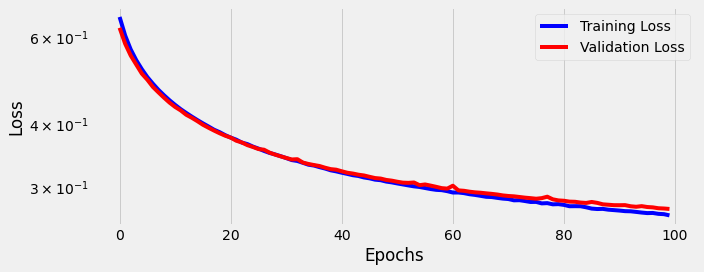

In [7]:
###############################################################################################
# train the model - only takes about 10s for 20 epochs, 1m for 100 epochs
sbs_oh = StepByStep(model, loss_fn, optimizer)
sbs_oh.set_loaders(train_loader, val_loader)
sbs_oh.train(100)

# plot loss over epochs
fig = sbs_oh.plot_losses()

In [8]:
##############################################################
# how well does this model do with data it has never seen?
sbs_oh.model.eval()
out = sbs_oh.model(test_features_tensor)

# record detailed predictions for this model
df_experiment_results = pd.DataFrame({'method': test_input_method,
                                      'params': num_params,
                                      'params_train': num_params_train, 
                                      'msg_id': df_test['msg_id'],
                                      'label': df_test['label'],
                                      'p_sigmoid': torch.sigmoid(out).squeeze().tolist()}) 
df_experiment_results['pred'] = np.where(df_experiment_results['p_sigmoid']>0.5, 1, 0)
df_experiment_results['correct'] = np.where(df_experiment_results['pred']==df_experiment_results['label'], 1, 0)
df_experiment_results['tp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==1), 1, 0)
df_experiment_results['fp'] = np.where((df_experiment_results['pred']==1) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['tn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==0), 1, 0)
df_experiment_results['fn'] = np.where((df_experiment_results['pred']==0) & (df_experiment_results['label']==1), 1, 0)

# calculate metrics
tp = df_experiment_results["tp"].sum()
fp = df_experiment_results["fp"].sum()
tn = df_experiment_results["tn"].sum()
fn = df_experiment_results["fn"].sum()
prec = tp/(tp+fp)
recall = tp/(tp+fn)

# show our metrics
print("ACC: ",df_experiment_results["correct"].mean())
print("Precision: ",prec)
print("Recall: ", recall)

# save results to local CSV
file_name = 'results_'+test_input_method+'.csv'
df_experiment_results.to_csv(file_name, index=False) 
files.download(file_name)
print("\n\n",df_experiment_results.head(10))

ACC:  0.892
Precision:  0.9024640657084189
Recall:  0.879


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



             method  params  params_train  msg_id  label  p_sigmoid  pred  \
36  word2vec (300)     301           301   20769      0   0.448609     0   
38  word2vec (300)     301           301   11187      0   0.537485     1   
39  word2vec (300)     301           301   18221      0   0.401880     0   
41  word2vec (300)     301           301   32319      1   0.984201     1   
42  word2vec (300)     301           301   14216      0   0.037503     0   
48  word2vec (300)     301           301   33569      1   0.899635     1   
61  word2vec (300)     301           301   19091      0   0.731154     1   
65  word2vec (300)     301           301   10759      0   0.002211     0   
72  word2vec (300)     301           301   31449      1   0.925674     1   
74  word2vec (300)     301           301   44112      1   0.999957     1   

    correct  tp  fp  tn  fn  
36        1   0   0   1   0  
38        0   0   1   0   0  
39        1   0   0   1   0  
41        1   1   0   0   0  
42        